<a href="https://colab.research.google.com/github/juneilsam/mariah_carey_christmas/blob/main/mariah_analysis_rf_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mariah Carey, 'All I want for Christmas is you' 음원 순위 예측 프로젝트**

- 활용방안

  : 최근 음원 저작권을 주식처럼 매매하고 시가가 매겨지는데, 음원 순위 예측을 통해 적절한 매도, 매수 시기를 예측할 수 있다. 다른 음원에 적용하여, 매도, 매수할 음원을 찾는 데에도 활용할 수 있다.

  : 음악은 광고, 마케팅 등 다방면에 쓰이는데, 음원을 활용할 적정 시기를 예측할 수 있다.

**목차**

1.[준비하기](https://colab.research.google.com/drive/1ZJXhw4hYSehBP7qfFI0Q5hOkR-fnFxk4?authuser=3#scrollTo=_OC73_-5NfLa&line=1&uniqifier=1)

2.[탐색적 데이터 분석](https://colab.research.google.com/drive/1ZJXhw4hYSehBP7qfFI0Q5hOkR-fnFxk4?authuser=3#scrollTo=dvYWCEEMOSde&line=1&uniqifier=1)

3.[데이터 분리하기](https://colab.research.google.com/drive/1ZJXhw4hYSehBP7qfFI0Q5hOkR-fnFxk4?authuser=3#scrollTo=-JXVFFwBPMHF&line=1&uniqifier=1)

4.[LSTM을 활용한 시계열 예측](https://colab.research.google.com/drive/1ZJXhw4hYSehBP7qfFI0Q5hOkR-fnFxk4?authuser=3#scrollTo=LEAMwzOgPphn&line=1&uniqifier=1)

5.[RandomForest Classifier](https://colab.research.google.com/drive/1ZJXhw4hYSehBP7qfFI0Q5hOkR-fnFxk4?authuser=3#scrollTo=_6zQ1RZMM0Uz&line=1&uniqifier=1)

6.[RandomForest Regressor](https://colab.research.google.com/drive/1ZJXhw4hYSehBP7qfFI0Q5hOkR-fnFxk4?authuser=3#scrollTo=B1rbgxFENDAG&line=3&uniqifier=1)


# 1. 준비하기

## 1-1. 기본 라이브러리 준비하기

In [ ]:
pip install -q pyyaml h5py  # HDF5 포맷으로 모델을 저장하기 위해서 필요합니다.

In [ ]:
# 기본 라이브러리 불러오기
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

# 머신러닝, 딥러닝 라이브러리 불러오기
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, BatchNormalization
import keras.backend as K
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## 1-2. CSV 데이터 불러오기

In [ ]:
# 파일 경로 지정
filename = '/content/drive/MyDrive/mariah_xmas.csv'

# 파일 불러오기(날짜 데이터 형식에 맞춤)
df = pd.read_csv(filename, encoding = 'cp949', parse_dates=["date"])

## 1-3. 데이터 확인하기

In [ ]:
# 불러온 데이터 확인하기
print("불러온 데이터 확인하기")
df

불러온 데이터 확인하기


,date,WDRank,USRank,USTemp,UKRank,UKTemp
0,2011-02-19,400.0,400.0,2.78,400.0,5.11
1,2011-02-20,400.0,400.0,-0.78,400.0,4.72
2,2011-02-21,400.0,400.0,-1.33,400.0,5.28
3,2011-02-22,400.0,400.0,-3.72,400.0,6.11
4,2011-02-23,400.0,400.0,-0.56,400.0,8.83
...,...,...,...,...,...,...
3603,2021-01-02,49.0,298.0,7.33,181.0,1.11
3604,2021-01-03,67.0,360.0,3.33,259.0,2.72
3605,2021-01-04,75.0,NaN,6.28,NaN,3.89
3606,2021-01-05,80.0,NaN,3.33,297.0,3.89


In [ ]:
# 데이터 정보 확인하기
print("데이터 정보 확인하기")
display(df.info())

데이터 정보 확인하기
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3608 entries, 0 to 3607
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3608 non-null   datetime64[ns]
 1   WDRank  3607 non-null   float64       
 2   USRank  3562 non-null   float64       
 3   USTemp  3608 non-null   float64       
 4   UKRank  3553 non-null   float64       
 5   UKTemp  3608 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 169.2 KB


None

피쳐명 안내

- WDRank : World Rank

- USRank : US Rank

- USTemp : US Temperature

- UKRank : UK Rank

- UKTemp : UK Temperature

## 1-4. 데이터 전처리

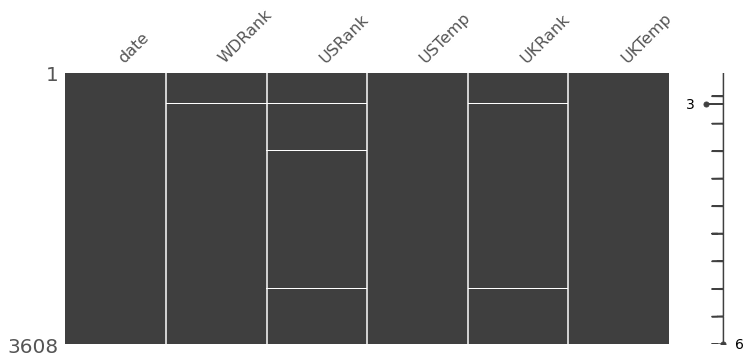

In [ ]:
# 결측치 확인하기

import missingno as msno

msno.matrix(df, figsize=(12,5))

이전 값(윗 행)을 이용한 결측치 변경

In [ ]:
# 결측치 변경(이전 값)
df = df.fillna(method='pad')

In [ ]:
# 셀 수 있는 값으로 변경
df['WDRank'] = pd.to_numeric(df['WDRank'])
df['USRank'] = pd.to_numeric(df['USRank'])
df['UKRank'] = pd.to_numeric(df['UKRank'])

In [ ]:
# 날짜 관련 피쳐 추가하기
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

In [ ]:
# 피쳐 추가하기
def addCol(rank):
  for i in df.index:
    # 랭킹 카테고리화(차트 아웃 : 1, 차트 인 : 0)
    if df.loc[i, rank] == 400:
      df.loc[i, f'{rank}cl'] = 0
    else:
      df.loc[i, f'{rank}cl'] = 1

    # 월-일 날짜 피쳐 추가하기
    df.loc[i, 'm-day'] = int(str(df.loc[i, 'month']) + str(df.loc[i, 'day']).zfill(2))

In [ ]:
# 피쳐 추가 함수 불러오기
for rank in ['WDRank', 'USRank', 'UKRank']:
  addCol(rank)

In [ ]:
# 데이터셋 상위 5줄
print('데이터 상위 5줄 : ')
display(df.head())

# 데이터셋 하위 5줄
print('\n데이터 하위 5줄 : ')
display(df.tail())

# 데이터셋 세부 정보
print('\n데이터셋 세부 정보 : ')
display(df.describe())

데이터 상위 5줄 : 


,date,WDRank,USRank,USTemp,UKRank,UKTemp,year,month,day,WDRankcl,m-day,USRankcl,UKRankcl
0,2011-02-19,400.0,400.0,2.78,400.0,5.11,2011,2,19,0.0,219.0,0.0,0.0
1,2011-02-20,400.0,400.0,-0.78,400.0,4.72,2011,2,20,0.0,220.0,0.0,0.0
2,2011-02-21,400.0,400.0,-1.33,400.0,5.28,2011,2,21,0.0,221.0,0.0,0.0
3,2011-02-22,400.0,400.0,-3.72,400.0,6.11,2011,2,22,0.0,222.0,0.0,0.0
4,2011-02-23,400.0,400.0,-0.56,400.0,8.83,2011,2,23,0.0,223.0,0.0,0.0



데이터 하위 5줄 : 


,date,WDRank,USRank,USTemp,UKRank,UKTemp,year,month,day,WDRankcl,m-day,USRankcl,UKRankcl
3603,2021-01-02,49.0,298.0,7.33,181.0,1.11,2021,1,2,1.0,102.0,1.0,1.0
3604,2021-01-03,67.0,360.0,3.33,259.0,2.72,2021,1,3,1.0,103.0,1.0,1.0
3605,2021-01-04,75.0,360.0,6.28,259.0,3.89,2021,1,4,1.0,104.0,1.0,1.0
3606,2021-01-05,80.0,360.0,3.33,297.0,3.89,2021,1,5,1.0,105.0,1.0,1.0
3607,2021-01-06,73.0,360.0,4.33,297.0,4.22,2021,1,6,1.0,106.0,1.0,1.0



데이터셋 세부 정보 : 


,WDRank,USRank,USTemp,UKRank,UKTemp,year,month,day,WDRankcl,m-day,USRankcl,UKRankcl
count,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000
mean,346.929324,349.858093,13.858736,349.785754,12.499066,2015.572616,6.583426,15.741685,0.149113,674.084257,0.149113,0.149113
std,128.550708,124.021208,9.495610,122.963956,5.410822,2.849665,3.424778,8.813303,0.356249,342.678182,0.356249,0.356249
min,1.000000,1.000000,-12.940000,1.000000,-10.280000,2011.000000,1.000000,1.000000,0.000000,101.000000,0.000000,0.000000
25%,400.000000,400.000000,6.220000,400.000000,8.560000,2013.000000,4.000000,8.000000,0.000000,405.000000,0.000000,0.000000
50%,400.000000,400.000000,14.110000,400.000000,12.390000,2016.000000,7.000000,16.000000,0.000000,704.000000,0.000000,0.000000
75%,400.000000,400.000000,22.500000,400.000000,16.720000,2018.000000,10.000000,23.000000,0.000000,1002.000000,0.000000,0.000000
max,400.000000,400.000000,34.220000,400.000000,29.060000,2021.000000,12.000000,31.000000,1.000000,1231.000000,1.000000,1.000000


In [ ]:
# 컬럼 정렬하기
df = df[['date', 'WDRank', 'WDRankcl', 'USRank', 'USRankcl', 'USTemp', 'UKRank', 'UKRankcl', 'UKTemp', 'year', 'month', 'day', 'm-day']]

In [ ]:
# 'date' 컬럼을 인덱스로 설정
df = df.set_index('date')

# 2. 탐색적 데이터 분석

## 2-1. 음원 순위 비교

시간순에 따른 음원 순위 추이


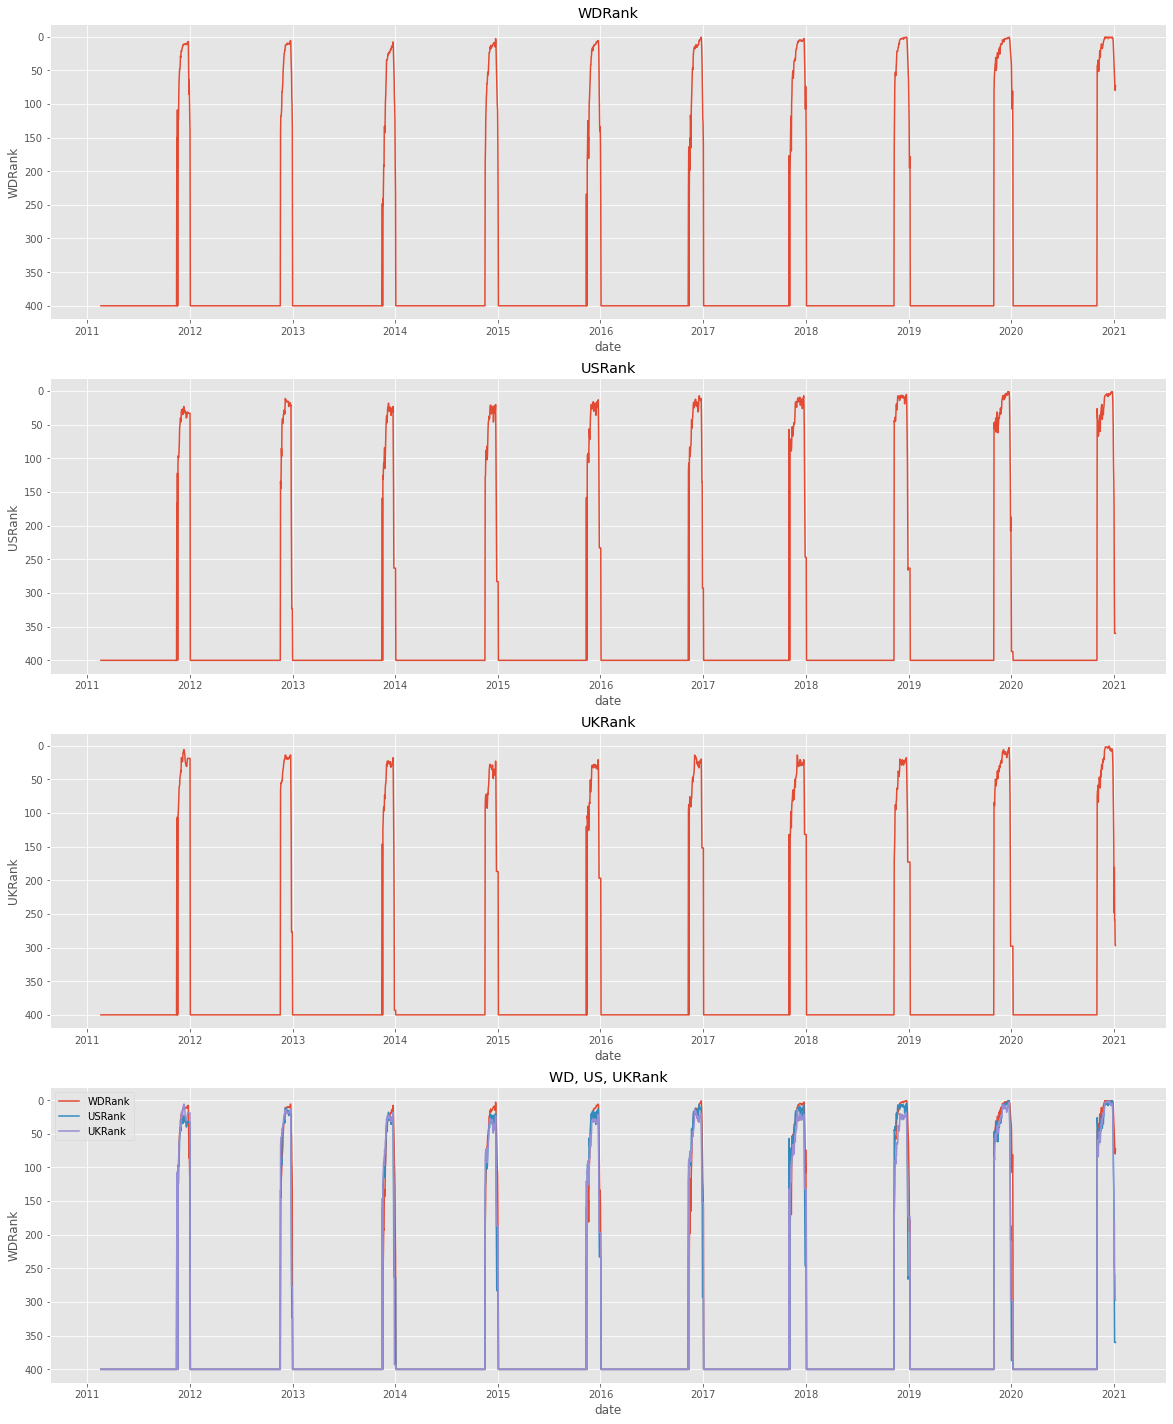

In [ ]:
# 세계, 미국, 영국 음원 순위 비교
print("시간순에 따른 음원 순위 추이")

figure, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, ncols = 1)
figure.set_size_inches(20, 25)

# 세계 순위 추이
sns.lineplot(data=df, x="date", y="WDRank", ax=ax1)

# 미국 순위 추이
sns.lineplot(data=df, x="date", y="USRank", ax=ax2)

# 영국 순위 추이
sns.lineplot(data=df, x="date", y="UKRank", ax=ax3)

# 세계, 미국, 영국 순위 추이
sns.lineplot(data=df, x="date", y="WDRank", ax=ax4)
sns.lineplot(data=df, x="date", y="USRank", ax=ax4)
sns.lineplot(data=df, x="date", y="UKRank", ax=ax4)

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()

ax1.set(title="WDRank")
ax2.set(title="USRank")
ax3.set(title="UKRank")
ax4.set(title="WD, US, UKRank")
plt.legend(["WDRank", "USRank", "UKRank"], loc=2)

## 2-2. 영미 기온 비교

미국, 영국 기온 비교


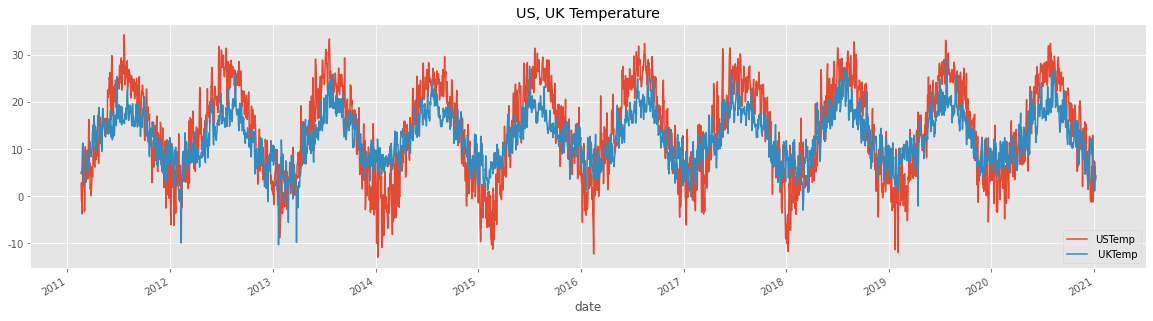

In [ ]:
# 미국, 영국 기온 비교
print("미국, 영국 기온 비교")
plt.figure(figsize=(20, 5))
df['USTemp'].plot()
df['UKTemp'].plot()
plt.title('US, UK Temperature')
plt.legend(['USTemp', ' UKTemp'], loc=4)

## 2-3. 세계 순위가 1위인 날짜의 영미 음원 순위

In [ ]:
# 세계 순위 1위 날짜의 미국, 영국 순위 비교

print('세계 1위 날짜 순위 비교')
data = {}
DT = []
WD = []
US = []
UK = []

for i in df.index:
  if df.loc[i, 'WDRank'] == 1:
    DT.append(i.date())
    WD.append(df.loc[i, 'WDRank'])
    US.append(df.loc[i,'USRank'])
    UK.append(df.loc[i,'UKRank'])
    data['날짜'] = DT
    data['세계'] = WD
    data['미국'] = US
    data['영국'] = UK

pd.DataFrame(data)

세계 1위 날짜 순위 비교


,날짜,세계,미국,영국
0,2016-12-24,1.0,11.0,20.0
1,2018-12-21,1.0,8.0,22.0
2,2018-12-22,1.0,9.0,23.0
3,2018-12-23,1.0,7.0,22.0
4,2018-12-24,1.0,5.0,18.0
5,2018-12-25,1.0,11.0,28.0
6,2019-12-24,1.0,1.0,3.0
7,2019-12-25,1.0,3.0,9.0
8,2020-11-29,1.0,8.0,6.0
9,2020-12-01,1.0,6.0,2.0


## 2-4. 세계, 미국, 영국 관련 피쳐 그래프화

세계 순위 관련 피쳐 그래프화

세계 순위 관련 피쳐 그래프


[Text(0.5, 1.0, 'WDRank Category Count')]

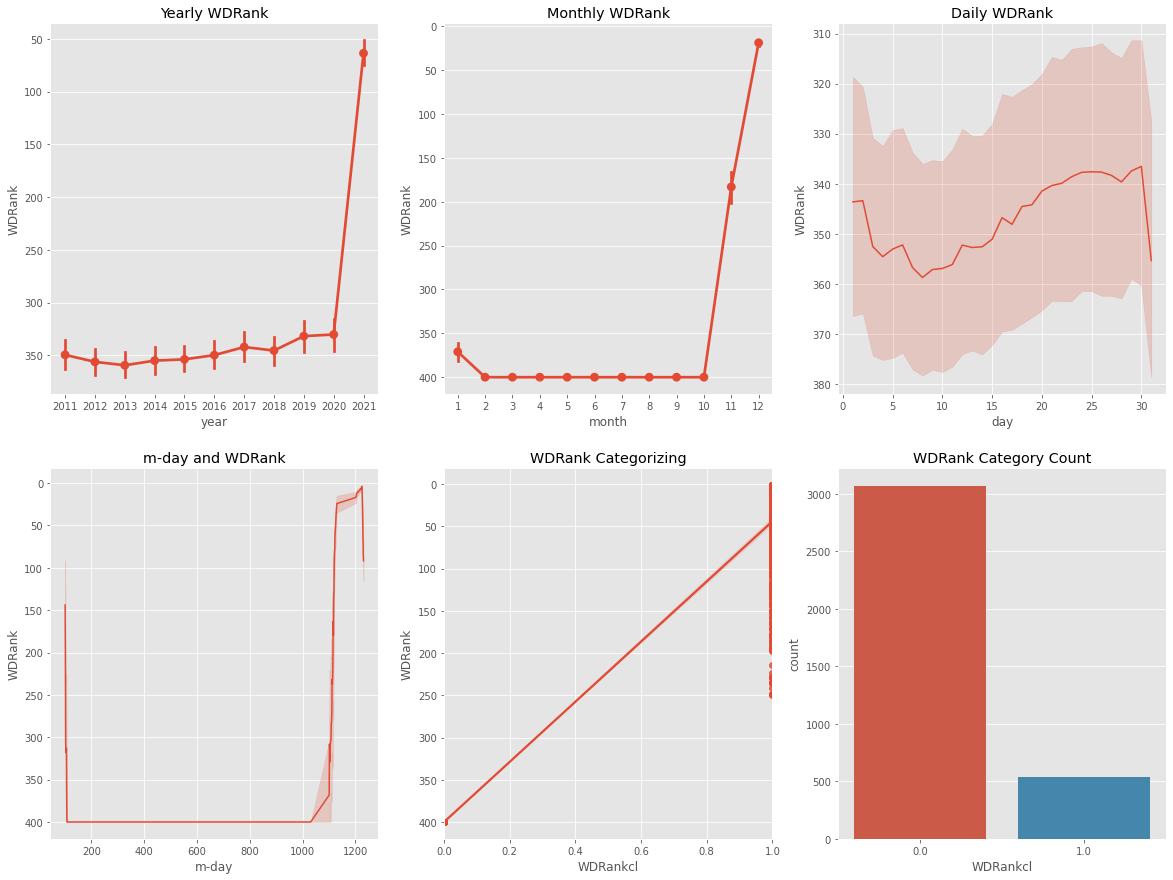

In [ ]:
# 세계 순위 관련 피쳐 그래프화
print("세계 순위 관련 피쳐 그래프")
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3)
figure.set_size_inches(20, 15)

# 세계 연간 순위
sns.pointplot(data=df, x="year", y="WDRank", ax=ax1)

# 세계 월간 순위
sns.pointplot(data=df, x="month", y="WDRank", ax=ax2)

# 세계 일간 순위
sns.lineplot(data=df, x="day", y="WDRank", ax=ax3)

# 세계 월-일간 순위
sns.lineplot(data=df, x="m-day", y="WDRank", ax=ax4)

# 세계 순위 카테고리 선형회귀 확인
sns.regplot(data=df, x="WDRankcl", y="WDRank", ax=ax5)

# 세계 순위 카테고리 카운팅
sns.countplot(data=df, x="WDRankcl", ax=ax6)

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()
ax5.invert_yaxis()

ax1.set(title="Yearly WDRank")
ax2.set(title="Monthly WDRank")
ax3.set(title="Daily WDRank")
ax4.set(title="m-day and WDRank")
ax5.set(title="WDRank Categorizing")
ax6.set(title="WDRank Category Count")

미국 순위 관련 피쳐 그래프화

[Text(0.5, 1.0, 'USRank and WDRank')]

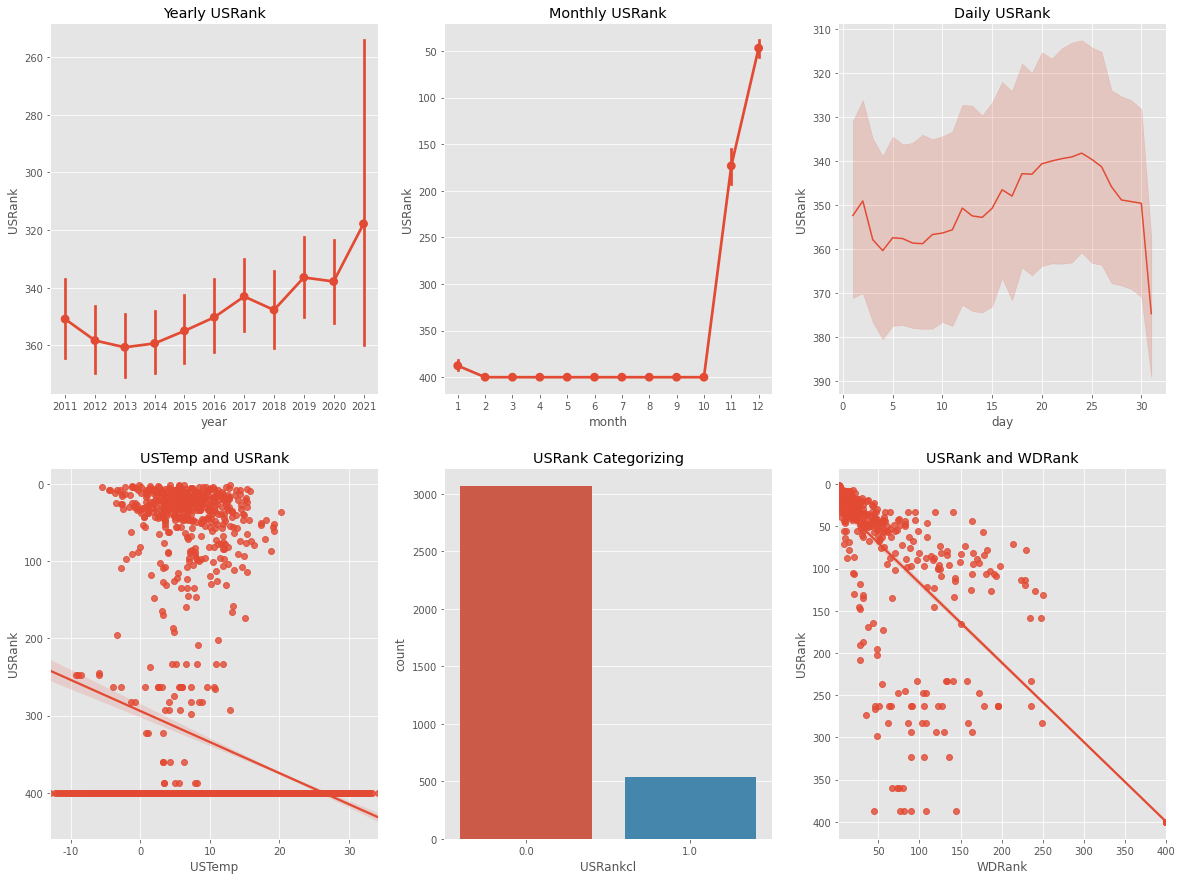

In [ ]:
# 미국 순위 관련 피쳐 그래프화
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3)
figure.set_size_inches(20, 15)

# 미국 연간 순위
sns.pointplot(data=df, x="year", y="USRank", ax=ax1)

# 미국 월간 순위
sns.pointplot(data=df, x="month", y="USRank", ax=ax2)

# 미국 일간 순위
sns.lineplot(data=df, x="day", y="USRank", ax=ax3)

# 미국 기온과 순위 선형회귀
sns.regplot(data=df, x="USTemp", y="USRank", ax=ax4)

# 미국 연간 순위 카테고리 카운팅
sns.countplot(data=df, x="USRankcl", ax=ax5)

# 세계-미국 순위 선형회귀
sns.regplot(data=df, x="WDRank", y="USRank", ax=ax6)

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()
ax6.invert_yaxis()

ax1.set(title="Yearly USRank")
ax2.set(title="Monthly USRank")
ax3.set(title="Daily USRank")
ax4.set(title="USTemp and USRank")
ax5.set(title="USRank Categorizing")
ax6.set(title="USRank and WDRank")

영국 순위 관련 피쳐 그래프화

[Text(0.5, 1.0, 'UKRank and WDRank')]

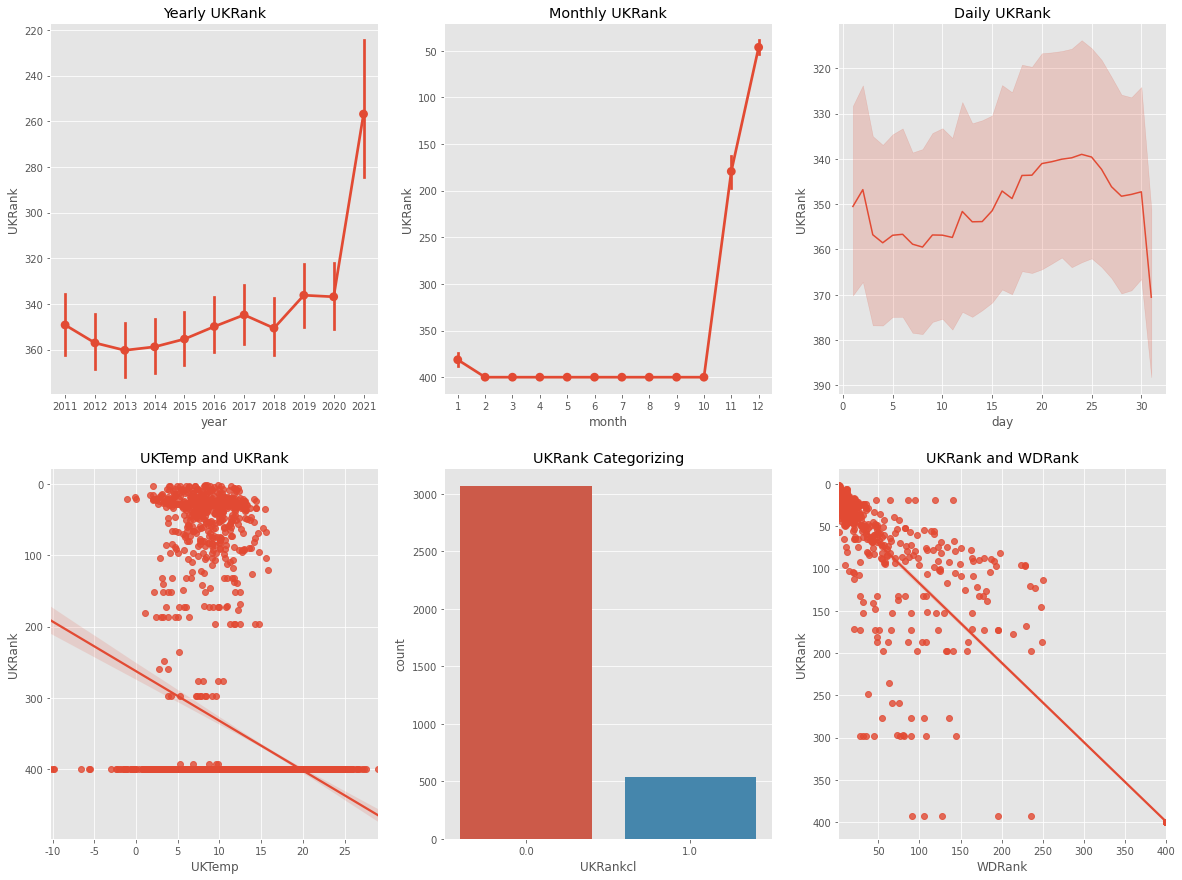

In [ ]:
# 영국 순위 관련 피쳐 그래프화
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3)
figure.set_size_inches(20, 15)

# 영국 연간 순위
sns.pointplot(data=df, x="year", y="UKRank", ax=ax1)

# 영국 월간 순위
sns.pointplot(data=df, x="month", y="UKRank", ax=ax2)

# 영국 일간 순위
sns.lineplot(data=df, x="day", y="UKRank", ax=ax3)

# 영국 기온-순위 선형회귀
sns.regplot(data=df, x="UKTemp", y="UKRank", ax=ax4)

# 영국 순위 카테고리 카운팅
sns.countplot(data=df, x="UKRankcl", ax=ax5)

# 세계-영국 순위 선형회귀
sns.regplot(data=df, x="WDRank", y="UKRank", ax=ax6)

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()
ax6.invert_yaxis()

ax1.set(title="Yearly UKRank")
ax2.set(title="Monthly UKRank")
ax3.set(title="Daily UKRank")
ax4.set(title="UKTemp and UKRank")
ax5.set(title="UKRank Categorizing")
ax6.set(title="UKRank and WDRank")

## 2-5. 피쳐간 상관계수 확인

In [ ]:
# 피쳐간 상관계수 계산
corrMatt = df.corr()

In [ ]:
# 그래프상 상관관계를 나타낼 삼각형 형태(mask)
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

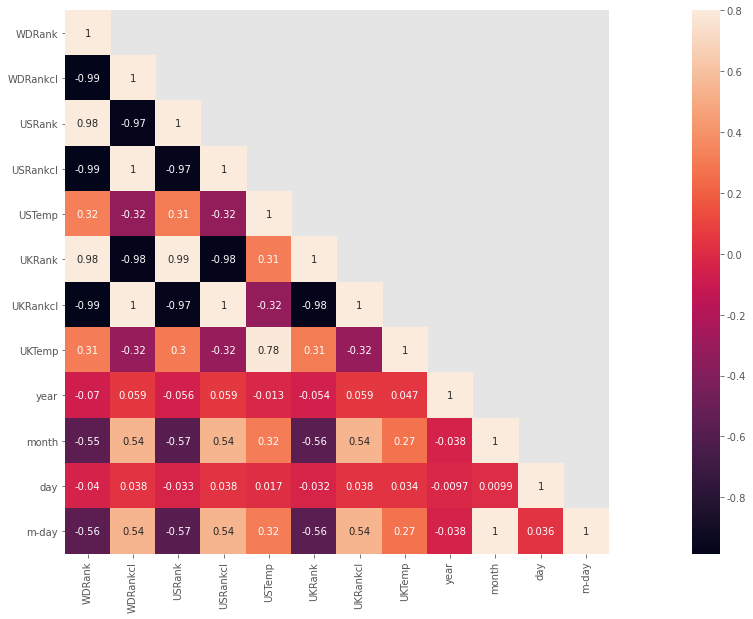

In [ ]:
# 상관계수를 히트맵으로 표현

fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

# 3. 데이터 분리하기

## 3-1. 날짜기준 데이터 분리

In [ ]:
# 날짜기준, 훈련데이터와 테스트데이터 분리
split_date = pd.Timestamp('2018-12-31')

train = df.loc[:split_date, :]
test = df.loc[split_date: , :]

## 3-2. 훈련데이터와 테스트데이터 확인

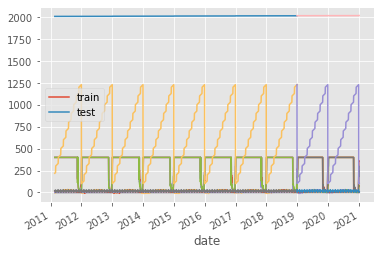

In [ ]:
# 날짜기준, 훈련데이터와 테스트데이터 분리
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

# 4. LSTM을 활용한 시계열 예측

## 4-1. LSTM 데이터 준비

스케일링 후, 윈도우 생성

In [ ]:
# 최대-최소 스케일링
scaler = MinMaxScaler()

# 각각 스케일링을 적용한 train data와 test data에서 값만을 추출
trainv = scaler.fit_transform(train.values)
testv = scaler.transform(test.values)

# 90일치 데이터로 window 생성
lookback = 90 
X_train = []
X_test = []
y_train = []
y_test = []

# train data
for i in range(len(trainv) - lookback):
  X_train.append(trainv[i: i + lookback].tolist())
  y_train.append(trainv[i + lookback, [0]].tolist())

# test data
for j in range(len(testv) - lookback):
    X_test.append(testv[j: j + lookback].tolist())
    y_test.append(testv[j + lookback, [0]].tolist())

In [ ]:
# numpy array로의 변환
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train[0:5], X_test[0:5], y_train[0:5], y_test[0:5]

In [ ]:
# 각 데이터별 shape 확인

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2781, 90, 12), (648, 90, 12), (2781, 1), (648, 1))

## 4-2. LSTM 모델 설정

In [ ]:
# 데이터 training 지표 설정
model = Sequential()

model.add(LSTM(90, return_sequences = True, input_shape=(90, 12), activation = 'relu')) # LSTM을 거친다.
model.add(LSTM(60, return_sequences = False, activation = 'relu')) # 한 번 더

model.add(Dense(1)) # 값을 하나 구한다. 예측한 WDRank
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 90)            37080     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                36240     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 73,381
Trainable params: 73,381
Non-trainable params: 0
_________________________________________________________________


## 4-3. LSTM 모델 학습

In [ ]:
# early_stop을 이용하여 조기에 학습이 완료될 시 종료될 수 있도록 함.
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

h = model.fit(X_train, y_train, batch_size = 10, epochs = 200,  callbacks=[early_stop])

Epoch 1/200
279/279 [==============================] - 23s 76ms/step - loss: 0.0680 - acc: 0.7677
Epoch 2/200
279/279 [==============================] - 22s 77ms/step - loss: 0.0046 - acc: 0.8503
Epoch 3/200
279/279 [==============================] - 21s 77ms/step - loss: 0.0039 - acc: 0.8437
Epoch 4/200
279/279 [==============================] - 22s 78ms/step - loss: 0.0033 - acc: 0.8570
Epoch 5/200
279/279 [==============================] - 22s 78ms/step - loss: 0.0024 - acc: 0.8555
Epoch 6/200
279/279 [==============================] - 22s 78ms/step - loss: 0.0025 - acc: 0.8566
Epoch 00006: early stopping


## 4-4. 예측값 확인

Text(0.5, 1.0, 'WDRank Prediction')

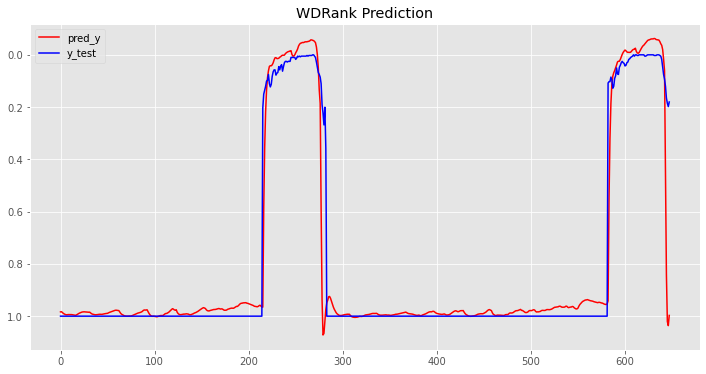

In [ ]:
# 예측값 확인
pred_y = model.predict(X_test)

plt.figure(figsize=[12, 6])
plt.plot(pred_y.ravel(), 'r-', label='pred_y')
plt.plot(y_test.ravel(), 'b-', label='y_test')
plt.gca().invert_yaxis()
plt.legend()
plt.title('WDRank Prediction')

Text(0.5, 1.0, 'Loss')

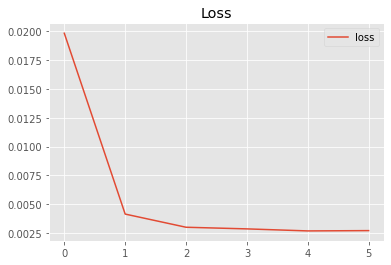

In [ ]:
plt.plot(h.history['loss'], label = 'loss')
plt.legend() # 우측 상단 선
plt.title('Loss')

## 4-5. 모델 저장하기

In [ ]:
# 모델 저장하기
model.save('/content/drive/MyDrive/lstm_model2.h5')

# 5. RandomForest Classifier

랜덤 포레스트 분류기를 이용하여 음원 순위 차트인 여부 구분하기

## * 모델 최적 파라미터 설정

미리 시행한 값을 적용하고 주석으로 작성

In [ ]:
"""
params ={'n_estimators':[100], 'max_depth':[6,8,10,12], 'min_samples_leaf':[8,12,18], 'min_samples_split':[8,16,20]}

train_set = np.asarray(train.values)

# split into input and output columns
trainX, trainy = train_set[:, 1:], train_set[:, 1]

rf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(trainX,trainy)

"""

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=0,
                                     

In [ ]:
"""
print('최고 점수 : ', grid_cv.best_score_)
print('최적 파라미터 : ', grid_cv.best_params_)
print('최고 모형 : ', grid_cv.best_estimator_)
"""

최고 점수 :  1.0
최적 파라미터 :  {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 모형 :  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


## 5-1. RFC 모델 구현, 저장

나머지 피쳐들을 활용하여 WDRankcl(세계 순위 차트인 여부)를 판단함

차트 인 : 1

차트 아웃 : 0

In [ ]:
# 학습 데이터 분리, 랜덤포레스트 모델 구현, 저장

def random_forest_classify(train_set, testX):
  
  # 학습 데이터 셋을 리스트에서 넘파이 배열로 변환
  train_set = np.asarray(train_set)

  # 학습 기준이 되는 컬럼과 분류 대상 컬럼을 구분
  trainX, trainy = train_set[:, 2:], train_set[:, 1]

  # fit model
  model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

  model.fit(trainX, trainy)
  joblib.dump(model, 'cmodel2.joblib')

  # 예측을 수행
  yhat = model.predict([testX])

  return yhat[0]

## 5-2. 데이터셋 분리, 학습 시행

In [ ]:
predictions = []
expections = []

# 학습 데이터 셋에 추가적으로 사용될 수 있는 'history' 리스트 생성
history = [x for x in train.values]
  
# 확인 데이터셋에서 하나씩 추출하여 모델에 사용
for i in tqdm(range(len(test))):
  
  # 확인 데이터셋을 분리
  testX, testy = test.values[i][2:], test.values[i][1]

  # 추출된 데이터를 사용하여 모델 구현, 예측 수행
  yhat = random_forest_classify(history, testX)

  # 예측 데이터 저장
  predictions.append(yhat)

  # 추가적으로 사용될 수 있는 데이터 저장
  history.append(test.values[i])

  # 학습에 사용되었던 데이터 저장
  expections.append(testy)

# 정확도 계산
print('\n정확도 :', accuracy_score(expections, predictions))

100%|██████████| 738/738 [05:32<00:00,  2.22it/s]


정확도 : 1.0


## 5-3. 모델 저장하기

In [ ]:
# 모델 불러오기
cmodel = joblib.load('cmodel2.joblib')

# 모델 저장하기
f = ('/content/drive/MyDrive/cmodel3.joblib')
joblib.dump(cmodel, f)

['/content/drive/MyDrive/cmodel3.joblib']

## 5-4. 모델 피쳐 중요도 확인

In [ ]:
# 모델 피쳐 중요도 확인
pd.Series(sorted(cmodel.feature_importances_, reverse=True), train.columns[2:])

USRank      0.238893
USRankcl    0.235878
USTemp      0.204073
UKRank      0.148354
UKRankcl    0.127335
UKTemp      0.038207
year        0.007155
month       0.000103
day         0.000003
m-day       0.000000
dtype: float64

# 6. RandomForest Regressor

랜덤포레스트 회귀를 이용하여 WDRank(세계 순위) 예측하기

## * 모델 최적 파라미터 설정

미리 시행한 값을 적용하고 주석으로 작성

In [ ]:
"""
params ={'n_estimators':[100], 'max_depth':[6,8,10,12], 'min_samples_leaf':[8,12,18], 'min_samples_split':[8,16,20]}

train_set = np.asarray(train.values)

# split into input and output columns
trainX, trainy = train_set[:, 1:], train_set[:, 1]

rf = RandomForestRegressor(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(trainX,trainy)
"""

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

In [ ]:
"""
print('최고 점수 : ', grid_cv.best_score_)
print('최적 파라미터 : ', grid_cv.best_params_)
print('최고 모형 : ', grid_cv.best_estimator_)
"""

최고 점수 :  0.9993095521567908
최적 파라미터 :  {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 모형 :  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)


## 6-1. RFR 모델 구현, 저장

나머지 피쳐들을 활용하여 WDRank(세계 순위)를 예측

In [ ]:
# 학습 데이터 분리, 랜덤포레스트 모델 구현, 저장

def random_forest_regressor(train_set, testX):
  
  # 학습 데이터 셋을 리스트에서 넘파이 배열로 변환
  train_set = np.asarray(train_set)

  # 학습 기준이 되는 컬럼과 분류 대상 컬럼을 구분
  trainX, trainy = train_set[:, 1:], train_set[:, 0]

  # fit model
  model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)
  model.fit(trainX, trainy)
  joblib.dump(model, 'rmodel.joblib')

  # 예측을 수행
  yhat = model.predict([testX])

  return yhat[0]

## 6-2. 데이터셋 분리, 학습 시행

In [ ]:
predictions = []
expections = []

# 학습 데이터 셋에 추가적으로 사용될 수 있는 'history' 리스트 생성
history = [x for x in train.values]
  
# 확인 데이터셋에서 하나씩 추출하여 모델에 사용
for i in tqdm(range(len(test))):
  
  # 확인 데이터셋을 분리
  testX, testy = test.values[i][1:], test.values[i][0]

  # 추출된 데이터를 사용하여 모델 구현, 예측 수행
  yhat = random_forest_regressor(history, testX)

  # 예측 데이터 저장
  predictions.append(yhat)

  # 추가적으로 사용될 수 있는 데이터 저장
  history.append(test.values[i])

  # 학습에 사용되었던 데이터 저장
  expections.append(testy)

# MAE 계산
error = mean_absolute_error(test.values[:, 0], predictions)
print('\nMAE : ', error)

100%|██████████| 738/738 [05:57<00:00,  2.07it/s]


MAE :  3.1272503363929713


## 6-3. 모델 저장하기

In [ ]:
# 모델 불러오기
rmodel = joblib.load('rmodel.joblib')

# 모델 저장하기
f = ('/content/drive/MyDrive/rmodel.joblib')
joblib.dump(rmodel, f)

['/content/drive/MyDrive/rmodel.joblib']

## 6-4. 모델 피쳐 중요도 확인

In [ ]:
# 모델 피쳐 중요도 확인
pd.Series(sorted(rmodel.feature_importances_, reverse=True), train.columns[1:])

WDRankcl    0.218987
USRank      0.214851
USRankcl    0.189401
USTemp      0.185566
UKRank      0.185417
UKRankcl    0.002003
UKTemp      0.001735
year        0.001508
month       0.000229
day         0.000212
m-day       0.000092
dtype: float64

## 6-5. 예측 데이터 시각화

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'test')]

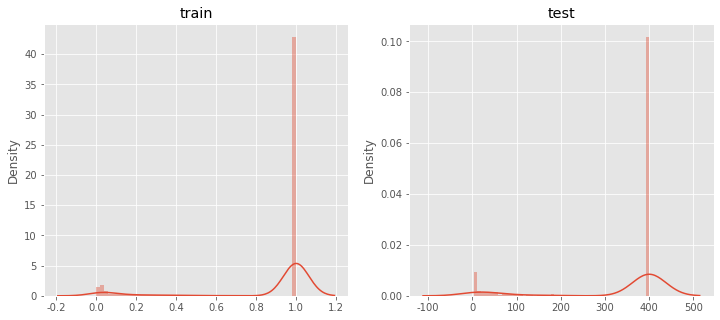

In [ ]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")